In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr,spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from statsmodels.api import Logit
import xgboost as xgb
# from imblearn.over_sampling import SMOTE
import random

import holidays
import requests
from time import sleep
from shutil import copyfile
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
# # To find out where the pyspark
# import findspark
# findspark.init()

# # Creating Spark Context
# from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import StringType, IntegerType, DecimalType, DoubleType

In [4]:
from pyspark.ml.feature import VectorAssembler,CountVectorizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
"""SimpleApp.py"""
spark = SparkSession.builder.appName("FirstSparkApp").getOrCreate()

In [120]:
df_spark = spark.read\
    .format("com.databricks.spark.csv")\
    .option("header", "true") \
    .option("mode", "DROPMALFORMED")\
    .option("inferSchema", "true")\
    .load('/home/arditto_trianggada3/Workspace/ds-ovo-test/dataset/spark_df/df_agg2')

In [121]:
class labelEnc():
    """
    Label Encoding
    """
    def __init__(self, categorical_features):
        self.key = categorical_features
        self.enc = [LabelEncoder() for c in categorical_features]
      
    def fit(self,X, y=None):
        y = np.array(X)
        self.categorical_feat_classes = {}
        for i in range(len(self.key)):
            c = self.key[i]
            self.enc[i] = self.enc[i].fit(y[:,c])
            self.categorical_feat_classes[c] = self.enc[i].classes_
        return self
      
    def transform(self,X):
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
      
    def fit_transform(self,X, y=None):
        self.fit(X,y)
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
    
class oneHotEnc():
    """
    One Hot Encoding
    """
    def __init__(self, categorical_features, fit_onehot):
        self.key = categorical_features
        self.enc = fit_onehot.set_params(categorical_features=categorical_features)

    def fit(self, X, y=None):
        if len(self.key)>0:
            #global categorical_onehot_idx,categorical_onehot_nval 
            self.enc = self.enc.fit(X,y)
            categorical_onehot_idx = self.enc.feature_indices_
            categorical_onehot_nval = self.enc.n_values_
            self.categorical_onehot_idx = categorical_onehot_idx
            self.categorical_onehot_nval = categorical_onehot_nval
        return self

    def transform(self, X):
        if len(self.key)>0:
            y = self.enc.transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        else:
            y=X
        return y
      
    def fit_transform(self,X, y=None):
        if len(self.key)>0:
            y = self.fit(X,y).transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        return y

def getColnames(le,onehotenc,df):
    if len(onehotenc.key)>0:
        categorical_onehot_idx = onehotenc.enc.feature_indices_
        categorical_onehot_nval = onehotenc.enc.n_values_
        colname = []
        k=0
        for i in categorical_onehot_idx[:-1]:
            feat = list_col_cat[k]
            for j in range(categorical_onehot_nval[k]):
                val = le.categorical_feat_classes[le.key[k]][j]
                colname.append("{}_{}".format(feat,val))
            k+=1
        lcol_num = [x for x in df.dtypes.index.values if not(x in list_col_cat)]
        for i in lcol_num:
            colname.append("{}".format(i))
    else:
        colname = df.columns.values
    return colname

In [122]:
## Save model
class bst_models():
  
  def __init__(self,colname, score_method="mean"):
    self.model = []
    self.colname = colname
    self.score_method = score_method
  
  def add_model(self, model):
    self.model.append(model)
    return self
  
  def predict(self,X):
    d = xgb.DMatrix(X,feature_names=self.colname)
    preds=[]
    for m in self.model:
      pred = m.predict(d)
      preds.append(list(pred))
      
    K = len(preds)
    nrow = len(preds[0])
    self.K = K
    self.nrow = nrow
    pred = []
    for i in range(nrow):
      sum1=0
      for j in range(K):
        if self.score_method == "max":
          sum1 = max(sum1, preds[j][i])
        else:
          sum1+=preds[j][i]
      if self.score_method == "max":
        pred.append(sum1)
      else:
        pred.append(sum1/K)
      
    return pd.Series(pred)
  
  def get_importances(self):
    imp = dict()
    cols = self.model[0].feature_names
    for col in cols:
      imp1=0
      k1 = 0
      for j in range(self.K):
        try:
          imp1+=self.model[j].get_score()[col]
        except (KeyError):
          pass
        k1 += 1
      imp[col] = imp1 / k1
    imp = pd.Series(imp).sort_values(ascending=False)
    return imp


In [123]:
df = df_spark.toPandas()

In [124]:
list_col_excl = ['hack_license','pickup_date','fare_amount_sum','tip_amount_sum','surcharge_sum']
df = df.drop(list_col_excl,axis=1)

In [125]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

pickup_dist_euclidean_max    0.013045
pickup_dist_euclidean_min    0.013045
pickup_time_in_secs_max      0.013045
pickup_time_in_secs_min      0.013045
earning_sum                  0.000000
fare_amount_min              0.000000
passenger_count_max          0.000000
pickup_longitude_min         0.000000
pickup_latitude_min          0.000000
pickup_longitude_max         0.000000
pickup_latitude_max          0.000000
dropoff_longitude_min        0.000000
dropoff_latitude_min         0.000000
dropoff_longitude_max        0.000000
dropoff_latitude_max         0.000000
trip_move_sublocal_count     0.000000
tip_amount_count             0.000000
surcharge_count              0.000000
work_time_in_secs            0.000000
pickup_hour_min              0.000000
pickup_hour_median           0.000000
pickup_hour_max              0.000000
trip_late_night_sum          0.000000
trip_night_sum               0.000000
trip_dist_euclidean_min      0.000000
trip_dist_euclidean_max      0.000000
trip_num    

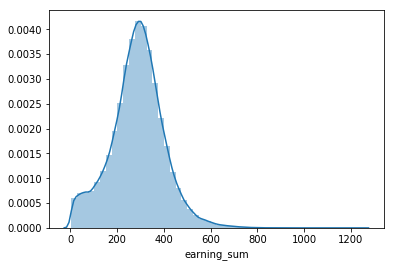

In [126]:
## ---------------------------------------------------------------------
## Null imputation
## ---------------------------------------------------------------------
data = df.copy()

## Menghitung Nilai Null
df_cnt = data.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)

## Mengambil column dengan Null lebih dari 20% kecuali n tahun restruk
feat_null = df_cnt[df_cnt>=0.2].index.tolist()
feat_null = [x for x in feat_null if not(x in [
 'earning_sum'
])]

## Membuang Kolom data dengan Null lebih dari 20%
lcol = data.columns.values
lcol = [x for x in lcol if not(x in feat_null)]
data = data.loc[:,lcol].reset_index(drop=True)

## Cek kolom data
tmp = data.apply(lambda x: x.count(), axis=0)
tmp = [tmp.index[i] for i in range(len(tmp)) if tmp[i]<data.shape[0]]

## Kolom identitas
exc_col = []
exc_col = np.append(exc_col,[
 'earning_sum'
])

## Missing Values Handling selain kolom identitas
for col in data.columns.values:
    if not(col in exc_col):
#         print(col)
        ds = data[col]
        typ = ds.dtype
        ## Ganti dengan modus untuk object dan categorical
        if typ==object:
            ds = ds.fillna(ds.mode()[0])
        elif type(typ)==pd.core.dtypes.dtypes.CategoricalDtype:
            ds = ds.fillna(ds.mode()[0])
        ## Untuk numeric ganti dengan median
        else:
            ds = ds.fillna(ds.median())
        data[col] = ds
        

### Data minus jadi 0
#for col in data.columns.values[M:N+1]:
#  data[col] = data[col].map(lambda x: x if x>0 else 0)
#data = data.reset_index(drop=True)

# target_count = data['fare_amount_sum'].value_counts()
# print('Class 0:', target_count[0])
# print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# target_count.plot(kind='bar', title='Count (TARGET)');

sns.distplot(data['earning_sum'])

df = data.copy()

In [127]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

earning_sum                  0.0
surcharge_count              0.0
passenger_count_max          0.0
pickup_longitude_min         0.0
pickup_latitude_min          0.0
pickup_longitude_max         0.0
pickup_latitude_max          0.0
dropoff_longitude_min        0.0
dropoff_latitude_min         0.0
dropoff_longitude_max        0.0
dropoff_latitude_max         0.0
fare_amount_min              0.0
tip_amount_count             0.0
trip_move_sublocal_count     0.0
work_time_in_secs            0.0
pickup_hour_min              0.0
pickup_hour_median           0.0
pickup_hour_max              0.0
trip_late_night_sum          0.0
trip_night_sum               0.0
trip_dist_euclidean_min      0.0
trip_dist_euclidean_max      0.0
pickup_time_in_secs_min      0.0
pickup_time_in_secs_max      0.0
pickup_dist_euclidean_min    0.0
pickup_dist_euclidean_max    0.0
trip_num                     0.0
dtype: float64

In [128]:
df.dtypes

trip_num                       int32
passenger_count_max            int32
pickup_longitude_min         float64
pickup_latitude_min          float64
pickup_longitude_max         float64
pickup_latitude_max          float64
dropoff_longitude_min        float64
dropoff_latitude_min         float64
dropoff_longitude_max        float64
dropoff_latitude_max         float64
fare_amount_min              float64
tip_amount_count               int32
surcharge_count                int32
trip_move_sublocal_count       int32
pickup_hour_min                int32
pickup_hour_median             int32
pickup_hour_max                int32
trip_late_night_sum            int32
trip_night_sum                 int32
trip_dist_euclidean_min      float64
trip_dist_euclidean_max      float64
pickup_time_in_secs_min      float64
pickup_time_in_secs_max      float64
pickup_dist_euclidean_min    float64
pickup_dist_euclidean_max    float64
work_time_in_secs              int32
earning_sum                  float64
d

In [129]:
# df['pickup_to_dropoff_local_set'] = df['pickup_to_dropoff_local_set'].map(lambda x: ','.join(np.sort(x.replace('[','').replace(']','').replace(', ',',').split(',')).tolist()))


In [130]:
list_col_excl1 = []

In [131]:
target_var = 'earning_sum'
dtype = df.dtypes.drop(list_col_excl1+[target_var])
list_col = dtype.index.values.tolist()

X = df.loc[:, list_col]
Y = df[target_var]

In [132]:
list_col_cat = [x for x in X.columns.values if ((X[x].dtypes==object) or (type(X[x].dtypes)==pd.core.dtypes.dtypes.CategoricalDtype))]
list_idx_cat = [i for i in range(len(X.columns.values)) if X.columns.values[i] in list_col_cat]

if len(list_col_cat)>0:
    # Label Encoding
    le = labelEnc(categorical_features=list_idx_cat)
    le.fit(X)
    categorical_feat_classes = le.categorical_feat_classes

    ### One Hot Encoding
    onehotenc = oneHotEnc(categorical_features=list_idx_cat, fit_onehot=OneHotEncoder())

    ### Feature scaling
    scaler = StandardScaler()

    ### Merge preprocess pipeline
    X_1 = le.transform(X)
    # X_train1 = le.transform(X_train)
    # X_test1 = le.transform(X_test)

    # Preprocessing
    pipeline = [
      # ('label_enc', le),
      ('one_hot_enc', onehotenc),
      #  ('scale', scaler),
      #  ('feature_selection', selector)
    ]
    pipeline_preprocess = Pipeline(pipeline)
    pipeline_preprocess.fit(X_1, Y)

    # Get colname of new dataset features
    onehotenc = pipeline_preprocess.steps[0][1]
    categorical_onehot_idx = onehotenc.enc.feature_indices_
    categorical_onehot_nval = onehotenc.enc.n_values_
    colname = []
    k=0
    for i in categorical_onehot_idx[:-1]:
      feat = list_col_cat[k]
      for j in range(categorical_onehot_nval[k]):
        val = categorical_feat_classes[list_idx_cat[k]][j]
        colname.append("{}_{}".format(feat,val))
      k+=1
    lcol_num = [x for x in dtype.index.values if not(x in list_col_cat)]
    for i in lcol_num:
      colname.append("{}".format(i))

    X_1 = pipeline_preprocess.transform(X_1)
    # X_train1 = pipeline_preprocess.transform(X_train1)
    # X_test1 = pipeline_preprocess.transform(X_test1)
else:
    X_1 = np.array(X)
    colname = [x for x in dtype.index.values if not(x in list_col_cat)]

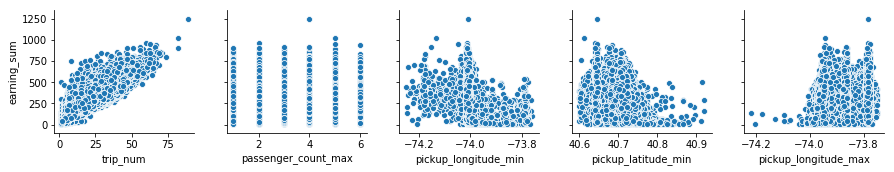

In [133]:
pp = sns.pairplot(data=df, y_vars=['earning_sum'], x_vars=list_col[0:5])

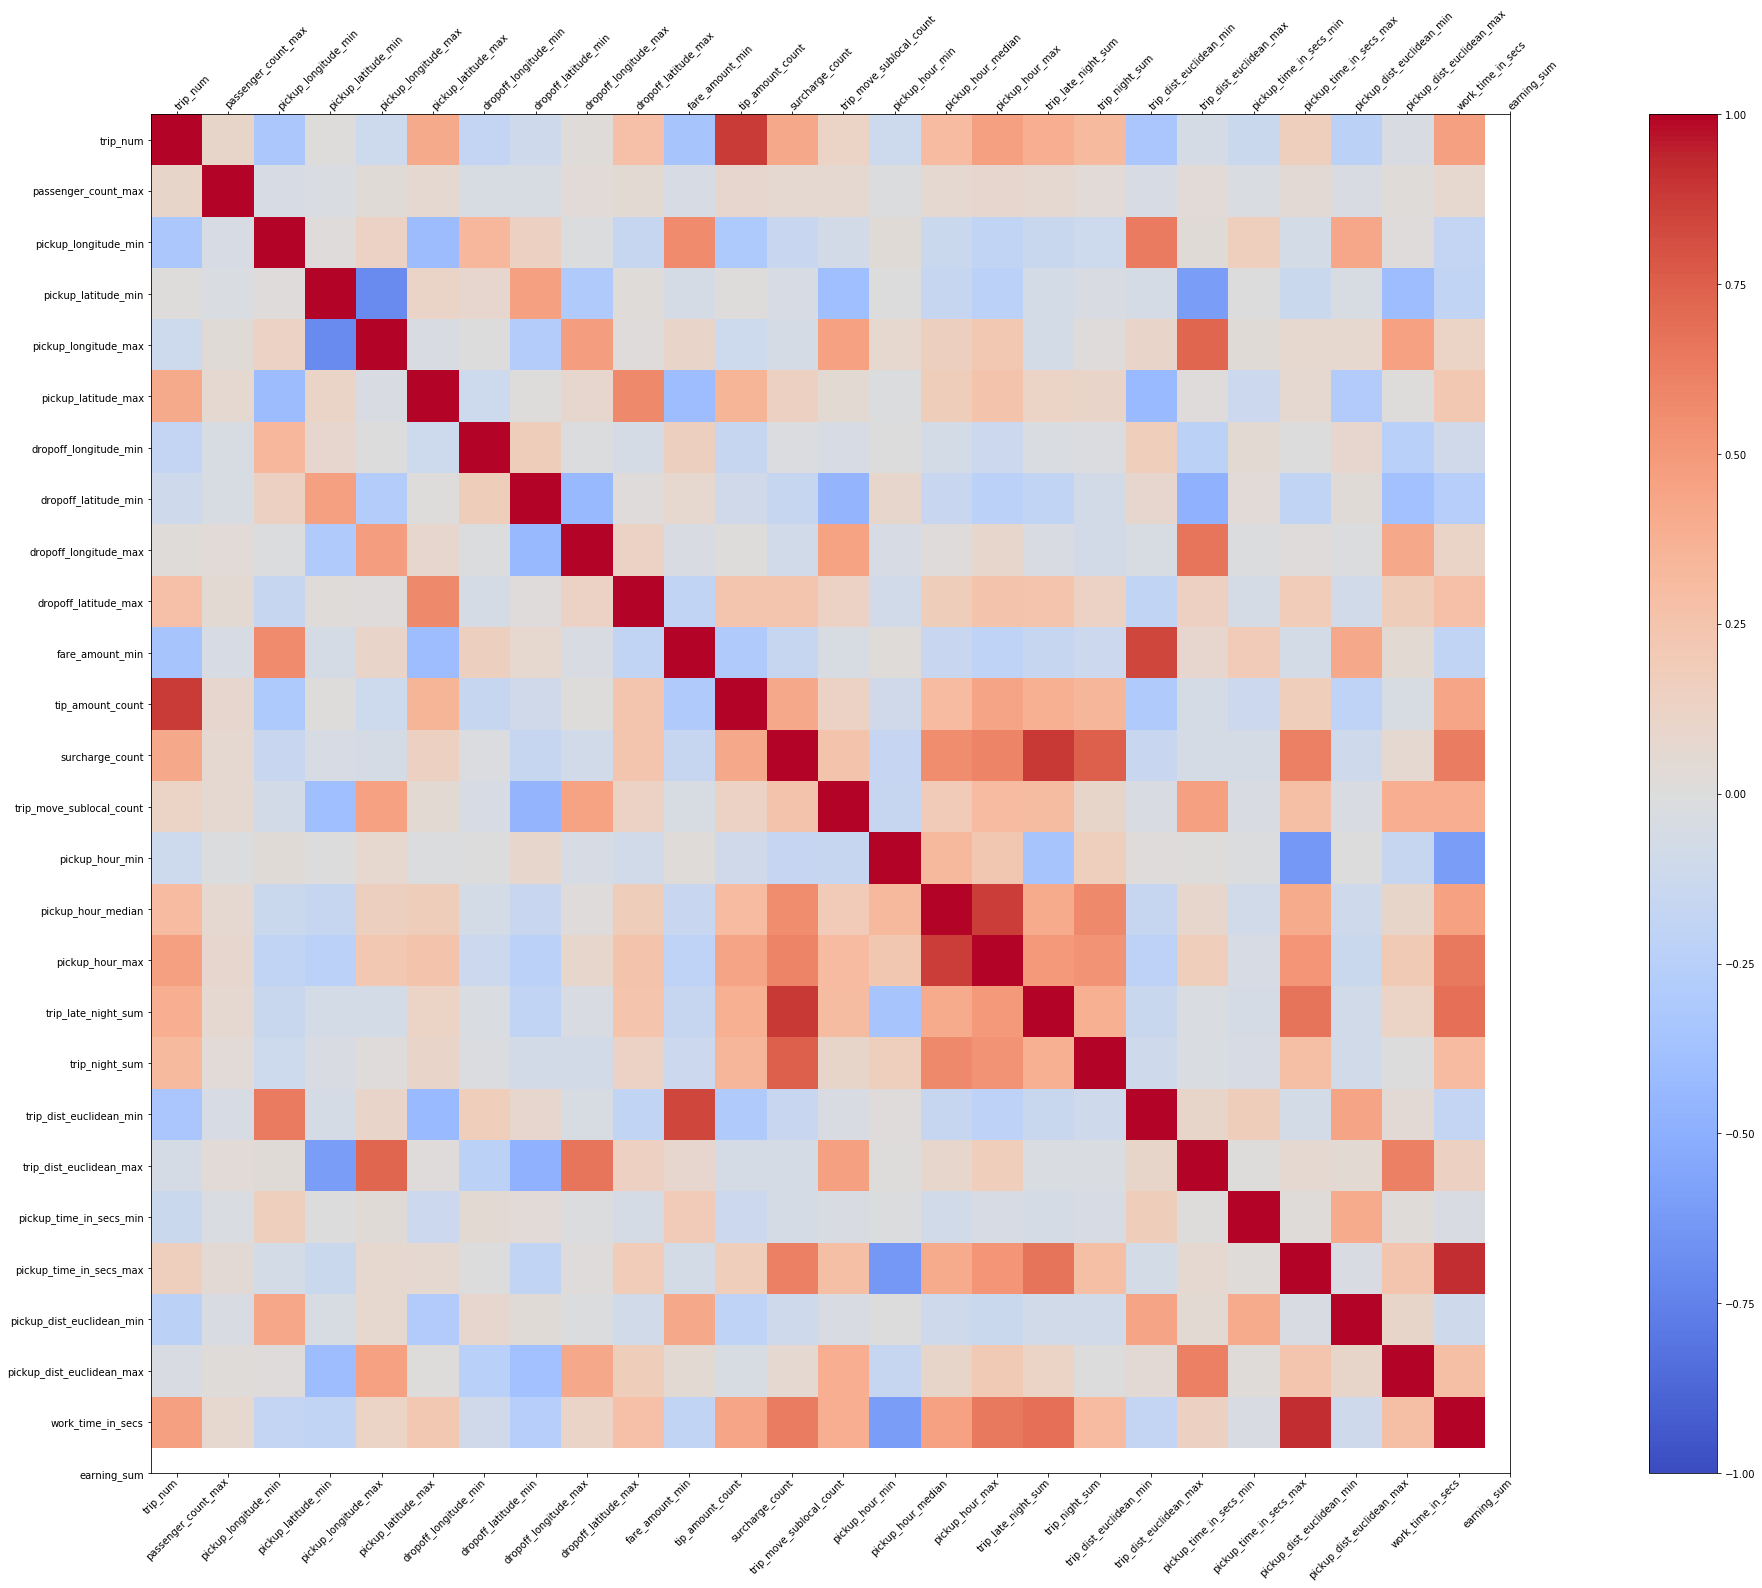

In [134]:
corr = X.corr()
fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

# ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
# ax.set_yticklabels(ax.get_yticklabels(),rotation=60)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

plt.show()
# plt.savefig('filename.png')

In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y, test_size=0.3, random_state=100)
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [136]:
### Resampling unbalanced dataset
# (1) Over-sampling with SMOTE
# def_ratio = 0.09
# sm = SMOTE(random_state=42, ratio={0:Y_train.value_counts()[0],1:int(Y_train.value_counts()[0]*(def_ratio/(1-def_ratio)))})
# sm.fit(X_train,Y_train)
# X_train_upsampled, Y_train_upsampled = sm.sample(X_train, Y_train)

X_train_upsampled = X_train
Y_train_upsampled = Y_train

In [137]:
dtrain = xgb.DMatrix(X_train_upsampled, label=Y_train_upsampled)
dtest  = xgb.DMatrix(X_test , label=Y_test )

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [138]:
K = 3
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [139]:
xgb_preds = []
bst = bst_models(colname=colname,score_method="mean")

In [140]:
def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = 1 - (sum((labels-preds )**2)/sum((labels-np.mean(labels))**2))
    return 'r2',r2

In [141]:
for train_index, test_index in kf.split(X_train_upsampled):
    train = X_train_upsampled; target_train = Y_train_upsampled
    train_X, valid_X = train[train_index], train[test_index]
    train_y, valid_y = target_train[train_index], target_train[test_index]
    
    # Create logistic regression object
    d_train = xgb.DMatrix(train_X, label=train_y,feature_names=colname)
    d_valid = xgb.DMatrix(valid_X, label=valid_y,feature_names=colname)

    xgb_params = {
        'eta': 0.03,
        'max_depth': 4,
        'subsample': 0.75,
        'objective': 'reg:linear',
        'silent': 1,
        'colsample_bytree': 0.8,
        'eval_metric': ['rmse']
    }
    early_stopping = 80
    num_round = 400
    evallist  = [(d_train,'train'), (d_valid,'eval')]
    
    model = xgb.train(
      xgb_params, 
      d_train, 
      num_round,
      evallist,
      feval=r2_metric,
      early_stopping_rounds=early_stopping
    )
    bst.add_model(model)

[0]	train-rmse:298.834	eval-rmse:299.694	train-r2:-5.7982	eval-r2:-5.86003
Multiple eval metrics have been passed: 'eval-r2' will be used for early stopping.

Will train until eval-r2 hasn't improved in 80 rounds.
[1]	train-rmse:290.208	eval-rmse:291.047	train-r2:-5.41138	eval-r2:-5.46989
[2]	train-rmse:281.777	eval-rmse:282.58	train-r2:-5.0443	eval-r2:-5.09892
[3]	train-rmse:273.591	eval-rmse:274.369	train-r2:-4.69822	eval-r2:-4.74964
[4]	train-rmse:265.726	eval-rmse:266.49	train-r2:-4.3753	eval-r2:-4.42414
[5]	train-rmse:258.116	eval-rmse:258.869	train-r2:-4.07181	eval-r2:-4.11835
[6]	train-rmse:250.648	eval-rmse:251.377	train-r2:-3.78258	eval-r2:-3.82639
[7]	train-rmse:243.412	eval-rmse:244.122	train-r2:-3.51044	eval-r2:-3.5518
[8]	train-rmse:236.508	eval-rmse:237.2	train-r2:-3.25821	eval-r2:-3.29736
[9]	train-rmse:229.701	eval-rmse:230.379	train-r2:-3.01662	eval-r2:-3.05374
[10]	train-rmse:223.183	eval-rmse:223.857	train-r2:-2.79188	eval-r2:-2.82748
[11]	train-rmse:216.883	eval-rms

In [142]:
# Predict testing data
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

In [143]:
compare = {
  'train': pd.DataFrame({'true':Y_train,'pred':y_train_pred}),
  'test': pd.DataFrame({'true':Y_test,'pred':y_test_pred})
}

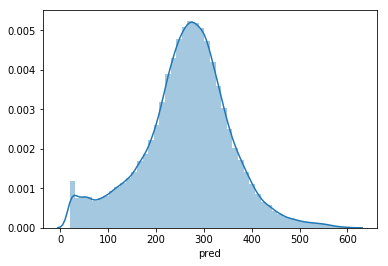

In [144]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

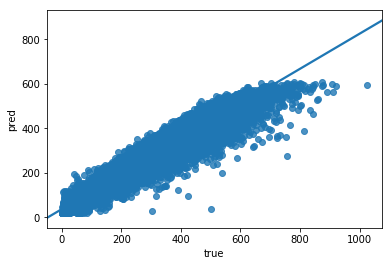

In [145]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)

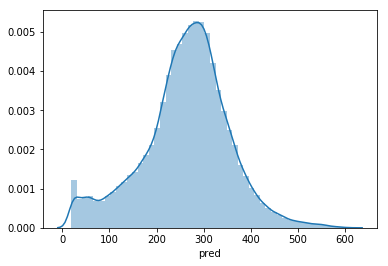

In [146]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

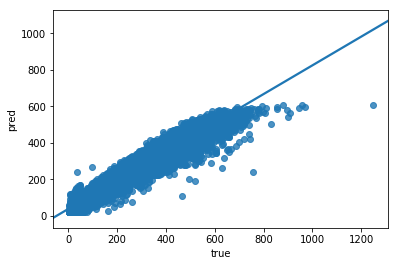

In [147]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)

In [148]:
df.earning_sum.describe()

count    166726.000000
mean        286.255534
std         114.234745
min           2.500000
25%         220.200000
50%         289.810000
75%         354.750000
max        1246.790000
Name: earning_sum, dtype: float64

In [149]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(Y_train,y_train_pred))))
print("R2  : {}".format(r2_score(Y_train,y_train_pred)))

RMSE: 43.349774952454226
R2  : 0.8567885087645365


In [150]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(Y_test,y_test_pred))))
print("R2  : {}".format(r2_score(Y_test,y_test_pred)))

RMSE: 43.230716270713984
R2  : 0.8549006621692363


In [151]:
for i,mdl in enumerate(bst.model):
    print("Model:{}".format(i))
    print(pd.Series(mdl.get_fscore()).sort_values(ascending=False))

Model:0
trip_num                     321
trip_dist_euclidean_max      184
work_time_in_secs            162
trip_move_sublocal_count     159
pickup_time_in_secs_max      109
tip_amount_count              76
dropoff_longitude_min         65
pickup_longitude_max          39
pickup_hour_max               27
pickup_latitude_min           24
dropoff_longitude_max         19
pickup_hour_median             5
surcharge_count                4
dropoff_latitude_min           4
pickup_longitude_min           3
trip_night_sum                 3
fare_amount_min                3
pickup_hour_min                2
pickup_latitude_max            1
trip_late_night_sum            1
pickup_dist_euclidean_max      1
pickup_dist_euclidean_min      1
pickup_time_in_secs_min        1
dropoff_latitude_max           1
dtype: int64
Model:1
trip_num                     321
trip_dist_euclidean_max      200
work_time_in_secs            162
trip_move_sublocal_count     161
pickup_time_in_secs_max      105
tip_amount_cou

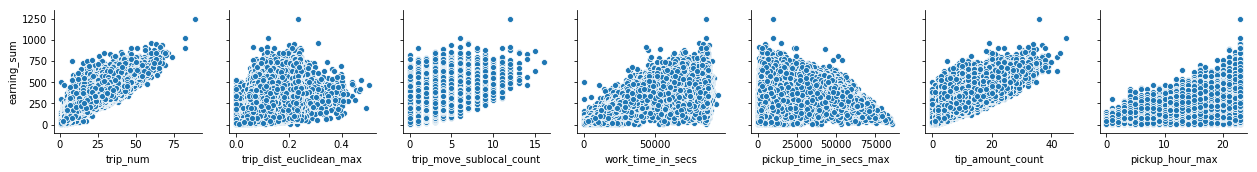

In [152]:
pp = sns.pairplot(data=df, 
                  y_vars=['earning_sum'], 
                  x_vars=[
                      'trip_num',
                      'trip_dist_euclidean_max',
                      'trip_move_sublocal_count',
                      'work_time_in_secs',
                      'pickup_time_in_secs_max',
                      'tip_amount_count',
                      'pickup_hour_max'
                ])